In [185]:
Threads.nthreads()

1

# Radar System Simulation

In [186]:
using Plots
using DSP
using FFTW
using Peaks

In [187]:
include("radarsim.jl")
using .radarsim;

### System Constants

In [188]:
samp_rate = 5e6  #hz
prf = 100 #Hz
duty_factor = .15; #.05
β = 1e6; #Pulse Bandwidth
repetitions = 128;
fc = 900_000_000; #Hz

Gt = 40; #dB
Gr = 45; #dB
system_loss = 6; #dB
coefficients = [1, 999, 41];

targets = [Target(560_094, 0)]
num_targets = length(targets);

In [189]:
τ = duty_factor * (1/prf);
λ = (1/fc) * c;

### Min and Max theoretical range

In [190]:

println("Maximum Range (km): ", (1/prf * c / 2) / 1000)
println("Minimum Range (km): ", (τ * c / 2) / 1000)


Maximum Range (km): 1498.96229
Minimum Range (km): 224.8443435


### Simulation

In [191]:
t, pulse_train = gen_pulse_train(repetitions, samp_rate, prf, τ, β, envelope_type="Rectangular", pulse_type="NOrderPoly", coefficients=coefficients);

In [192]:
rx_pulse_train, noise = sim_return(samp_rate, pulse_train, targets, fc=fc, system_loss=system_loss, Gt=Gt, Gr=Gr, SNR=100);

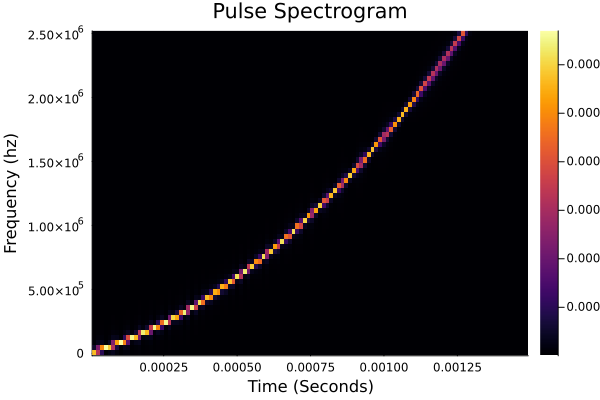

In [193]:
fft_size = 128;
spec = spectrogram(pulse_train[begin:round(Int, τ*samp_rate)], fft_size; fs=samp_rate); #+ pulse_train

heatmap(spec.time, LinRange(0,samp_rate/2, round(Int, fft_size/2)), spec.power[begin:round(Int, fft_size/2) , :], xguide="Time (Seconds)", yguide="Frequency (hz)", title="Pulse Spectrogram")

In [194]:
null, p = single_pulse(samp_rate, prf, τ, β, envelope_type="Rectangular", pulse_type="NOrderPoly", coefficients=coefficients);
pulse_compression = conv(rx_pulse_train, conj(reverse(p[begin:round(Int, τ*samp_rate)])));
pulse_compression = pulse_compression[1:length(rx_pulse_train)];

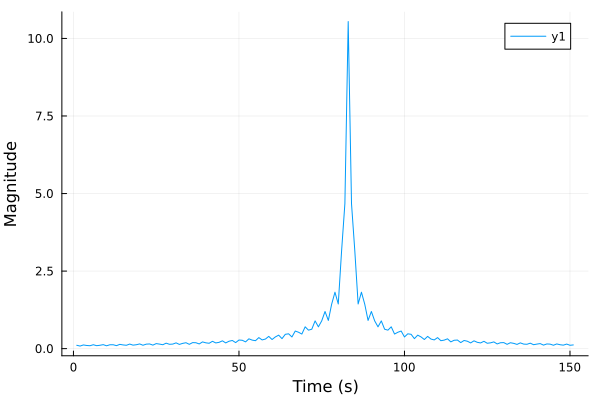

In [195]:
sigPower = abs.(pulse_compression)
sigPower = sigPower[1:26300]
plot(sigPower[26100:26250], xguide="Time (s)", yguide="Magnitude")

In [196]:
peaks = argmaxima(sigPower);
null, sigPowerMaxPeakIdx = findmax(sigPower);
peaksPeakIdx = first(findall(x->x==sigPowerMaxPeakIdx, peaks));
sigPowerSidelobeIdx = peaks[peaksPeakIdx+1];
sidelobePerformance = sigPower[sigPowerMaxPeakIdx] - sigPower[sigPowerSidelobeIdx];
println("Sibelobe Performance - Peak to Highest Sidelobe Peak Difference: ", sidelobePerformance)


Sibelobe Performance - Peak to Highest Sidelobe Peak Difference: 8.725969833456897


In [93]:
null, idx = findmax(sigPower)
println(idx)
println((idx)/samp_rate)
estimatedRange  = (t[idx]*299_792_458)/2
rangeError = abs(estimatedRange - 560_094)
println("Estimated Distance to Target (m): ", estimatedRange)
println("Range Error (m): ", rangeError)

1476182
0.2952364
Estimated Distance to Target (m): 4.42548230235356e7
Range Error (m): 4.36947290235356e7


In [70]:
function range_accuracy(coeff)
    samp_rate = 5e6  #hz
    prf = 100 #Hz
    duty_factor = .15; #.05
    β = 1e6; #Pulse Bandwidth
    repetitions = 128;
    fc = 900_000_000; #Hz
    Gt = 40; #dB
    Gr = 45; #dB
    system_loss = 6; #dB
    targets = [Target(560_094, 0)]
    num_targets = length(targets);
    τ = duty_factor * (1/prf);
    λ = (1/fc) * c;
    t, pulse_train = gen_pulse_train(repetitions, samp_rate, prf, τ, β, envelope_type="Rectangular", pulse_type="NOrderPoly", coefficients=coeff);
    rx_pulse_train, noise = sim_return(samp_rate, pulse_train, targets, fc=fc, system_loss=system_loss, Gt=Gt, Gr=Gr, SNR=100);
    null, p = single_pulse(samp_rate, prf, τ, β, envelope_type="Rectangular", pulse_type="NOrderPoly", coefficients=coeff);
    pulse_compression = conv(rx_pulse_train, conj(reverse(p[begin:round(Int, τ*samp_rate)])));
    pulse_compression = pulse_compression[1:length(rx_pulse_train)];

    sigPower = abs.(pulse_compression);
    null, idx = findmax(sigPower[1:50000]);
    estimatedRange  = ((idx/samp_rate)*299_792_458)/2;
    rangeError = abs(estimatedRange - 560_094);
    return rangeError
end

range_accuracy([1,14,54,149])

224822.61353560002

In [109]:
function sidelobe_performance(coeff)
    samp_rate = 5e6  #hz
    prf = 100 #Hz
    duty_factor = .15; #.05
    β = 1e6; #Pulse Bandwidth
    repetitions = 128;
    fc = 900_000_000; #Hz
    Gt = 40; #dB
    Gr = 45; #dB
    system_loss = 6; #dB
    targets = [Target(560_094, 0)]
    num_targets = length(targets);
    τ = duty_factor * (1/prf);
    λ = (1/fc) * c;
    t, pulse_train = gen_pulse_train(repetitions, samp_rate, prf, τ, β, envelope_type="Rectangular", pulse_type="Increasing", coefficients=coeff);
    rx_pulse_train, noise = sim_return(samp_rate, pulse_train, targets, fc=fc, system_loss=system_loss, Gt=Gt, Gr=Gr, SNR=100);
    null, p = single_pulse(samp_rate, prf, τ, β, envelope_type="Rectangular", pulse_type="Increasing", coefficients=coeff);
    pulse_compression = conv(rx_pulse_train, conj(reverse(p[begin:round(Int, τ*samp_rate)])));
    pulse_compression = pulse_compression[1:length(rx_pulse_train)];

    peaks = argmaxima(sigPower);
    null, sigPowerMaxPeakIdx = findmax(sigPower);
    peaksPeakIdx = first(findall(x->x==sigPowerMaxPeakIdx, peaks));
    sigPowerSidelobeIdx = peaks[peaksPeakIdx+1];
    sidelobeDiff = sigPower[sigPowerMaxPeakIdx] - sigPower[sigPowerSidelobeIdx];
    return sidelobeDiff
end

sidelobe_performance([1])

8.602690037889031

In [16]:
function gradient(coefficients)
    Δ = 1
    gradient = zeros(length(coefficients))
    for i in 1:length(coefficients)
        coefficients_perturbed = copy(coefficients)
        coefficients_perturbed[i] += Δ
        gradient[i] = (range_accuracy(coefficients_perturbed) - range_accuracy(coefficients)) / Δ
    end
    return gradient
end

function gradient_descent(cost_fn, gradient_fn, initial_x, learning_rate, num_iterations)
    current_x = initial_x
    for i in 1:num_iterations
        gradient = gradient_fn(current_x)
        current_x -= learning_rate * gradient
        current_cost = cost_fn(current_x)
        println("Iteration $i: Cost = $current_cost")
    end
    return current_x
end

gradient_descent (generic function with 1 method)

In [17]:
initial_coefficients = [1,2,3]
learning_rate = 0.01
num_iterations = 50

optimal_coefficients = gradient_descent(range_accuracy, gradient, initial_coefficients, learning_rate, num_iterations)


MethodError: MethodError: no method matching gen_pulse_train(::Int64, ::Float64, ::Int64, ::Float64, ::Float64, ::Vector{Int64}; envelope_type="Rectangular", pulse_type="NOrderPoly")
Closest candidates are:
  gen_pulse_train(::Any, ::Any, ::Any, ::Any, ::Any; envelope_type, pulse_type, coefficients) at ~/radarSim/radarsim.jl:55

In [18]:
null, idx = findmax(sigPowerdB[1:50000])
estimatedRange  = ((idx/samp_rate)/(1/299_792_458))/2
rangeError = abs(estimatedRange - 560_094)

UndefVarError: UndefVarError: sigPowerdB not defined

### Range Doppler Plot

In [19]:
len = Int(1/prf * samp_rate);
range_stacked = reshape(pulse_compression, len, repetitions);

UndefVarError: UndefVarError: pulse_compression not defined

In [20]:
range_doppler = fft((range_stacked), (2,));

UndefVarError: UndefVarError: range_stacked not defined

In [21]:
maxRange = ((1/prf * c)/2)
maxDop = (prf*λ)/4;

rangeLabel = LinRange(0, maxRange , 13);
dopplerLabel = LinRange(-maxDop,maxDop,13);

rangeLabel = round.(Int, (rangeLabel ./ 1000));
dopplerLabel = round.(dopplerLabel, digits=2);

In [22]:
heatmap(20*log10.(abs.(range_doppler)), xlabel="Doppler (m/s)", ylabel="Range (km)", xticks=(LinRange(0,repetitions, 13), dopplerLabel), yticks=(LinRange(1,len,13), rangeLabel))

UndefVarError: UndefVarError: range_doppler not defined

### Theoretical Ambiguouity Function

In [23]:
v = 0:(maxDop * 4);

r = ((c^2)/(8*fc)) ./ v;

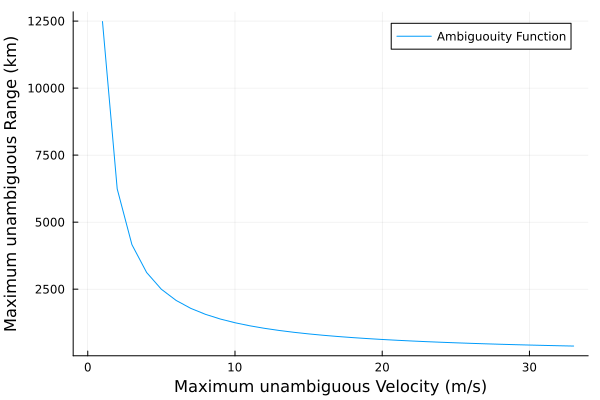

In [24]:
plot(v,r./1000, labels="Ambiguouity Function", xlabel="Maximum unambiguous Velocity (m/s)", ylabel="Maximum unambiguous Range (km)")